In [1]:
import sqlite3
corn = sqlite3.connect(':memory:')

In [2]:
db_path = 'example.db'
conn = sqlite3.connect(db_path , check_same_thread= False)

In [3]:
from langgraph.checkpoint.sqlite import SqliteSaver
memory = SqliteSaver(conn)

In [4]:
from langchain.chat_models import ChatOllama 
from langchain_core.messages import SystemMessage, HumanMessage, RemoveMessage

from langgraph.graph import END
from langgraph.graph import MessagesState

model = ChatOllama()
class State(MessagesState):
    summary: str

# Define the logic to call the model
def call_model(state: State):
    
    # Get summary if it exists
    summary = state.get("summary", "")

    # If there is summary, then we add it
    if summary:
        
        # Add summary to system message
        system_message = f"Summary of conversation earlier: {summary}"

        # Append summary to any newer messages
        messages = [SystemMessage(content=system_message)] + state["messages"]
    
    else:
        messages = state["messages"]
    
    response = model.invoke(messages)
    return {"messages": response}

def summarize_conversation(state: State):
    
    # First, we get any existing summary
    summary = state.get("summary", "")

    # Create our summarization prompt 
    if summary:
        
        # A summary already exists
        summary_message = (
            f"This is summary of the conversation to date: {summary}\n\n"
            "Extend the summary by taking into account the new messages above:"
        )
        
    else:
        summary_message = "Create a summary of the conversation above:"

    # Add prompt to our history
    messages = state["messages"] + [HumanMessage(content=summary_message)]
    response = model.invoke(messages)
    
    # Delete all but the 2 most recent messages
    delete_messages = [RemoveMessage(id=m.id) for m in state["messages"][:-2]]
    return {"summary": response.content, "messages": delete_messages}

# Determine whether to end or summarize the conversation
def should_continue(state: State):
    
    """Return the next node to execute."""
    
    messages = state["messages"]
    
    # If there are more than six messages, then we summarize the conversation
    if len(messages) > 6:
        return "summarize_conversation"
    
    # Otherwise we can just end
    return END

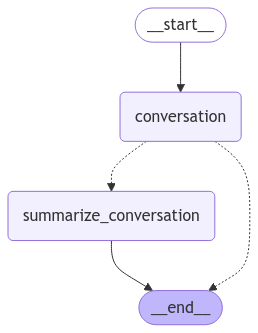

In [5]:
from IPython.display import Image, display
from langgraph.graph import StateGraph, START

# Define a new graph
workflow = StateGraph(State)
workflow.add_node("conversation", call_model)
workflow.add_node(summarize_conversation)

# Set the entrypoint as conversation
workflow.add_edge(START, "conversation")
workflow.add_conditional_edges("conversation", should_continue)
workflow.add_edge("summarize_conversation", END)

# Compile
graph = workflow.compile(checkpointer=memory)
display(Image(graph.get_graph().draw_mermaid_png()))

In [6]:
config = {'configurable':{'thread_id':1}}
try:
    for chunk in graph.stream(
        {'message': [HumanMessage(content='Hi i am lance')]}, 
        config, 
        stream_mode='updates'
    ):
        print(chunk)
except Exception as e:
    print(f"An error occurred: {e}")


An error occurred: Expected node messages to update at least one of ['messages', 'summary'], got {'message': [HumanMessage(content='Hi i am lance', additional_kwargs={}, response_metadata={})]}


In [7]:
# Create a thread
config = {"configurable": {"thread_id": "1"}}

# Start conversation
for chunk in graph.stream({"messages": [HumanMessage(content="hi! I'm Lance")]}, config, stream_mode="updates"):
    print(chunk)

{'conversation': {'messages': AIMessage(content="\nGreat to meet you too, Lance! *nodding* So, you're a big fan of the 49ers, huh? Which player is your favorite?", additional_kwargs={}, response_metadata={'model': 'llama2', 'created_at': '2024-12-06T04:39:23.865186Z', 'message': {'role': 'assistant', 'content': ''}, 'done_reason': 'stop', 'done': True, 'total_duration': 27467746292, 'load_duration': 12921300000, 'prompt_eval_count': 134, 'prompt_eval_duration': 5925620000, 'eval_count': 41, 'eval_duration': 7760447000}, id='run-be8ff47d-18ab-424a-9194-c9691688b616-0')}}


In [8]:
config = {"configurable": {"thread_id": "1"}}
input_message = HumanMessage(content= 'Tell me something about 49ers NFL team')

In [9]:
pip install aiosqlite


[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [10]:
async for event in graph.astream_events({'messages': [input_message]}, config, version= "v2"):

    print(f"Node : {event} ")

Node : {'event': 'on_chain_start', 'data': {'input': {'messages': [HumanMessage(content='Tell me something about 49ers NFL team', additional_kwargs={}, response_metadata={})]}}, 'name': 'LangGraph', 'tags': [], 'run_id': 'e64f6774-9b19-4b11-afd4-d4209040444e', 'metadata': {'thread_id': '1'}, 'parent_ids': []} 


NotImplementedError: The SqliteSaver does not support async methods. Consider using AsyncSqliteSaver instead.
from langgraph.checkpoint.sqlite.aio import AsyncSqliteSaver
Note: AsyncSqliteSaver requires the aiosqlite package to use.
Install with:
`pip install aiosqlite`
See https://langchain-ai.github.io/langgraph/reference/checkpoints/asyncsqlitesaverfor more information.

In [11]:
config = {"configurable": {"thread_id": "2"}}

# Start conversation
input_message = HumanMessage(content="hi! I'm Lance")
for event in graph.stream({"messages": [input_message]}, config, stream_mode="values"):
    for m in event['messages']:
        m.pretty_print()
    print("---"*25)

================================ Human Message =================================

hi! I'm Lance
================================ Human Message =================================

hi! I'm Lance
---------------------------------------------------------------------------
================================ Human Message =================================

hi! I'm Lance
================================ Human Message =================================

hi! I'm Lance
================================== Ai Message ==================================


Hey there, it's nice to meet you too, Lance! *smiles* Do you want to be friends?
---------------------------------------------------------------------------


In [13]:
config = {"configurable": {"thread_id": "3"}}
input_message = HumanMessage(content="Tell me about the 49ers NFL team")
async for event in graph.astream_events({"messages": [input_message]}, config, version="v2"):
    print(f"Node: {event['metadata'].get('langgraph_node','')}. Type: {event['event']}. Name: {event['name']}")

Node: . Type: on_chain_start. Name: LangGraph


NotImplementedError: The SqliteSaver does not support async methods. Consider using AsyncSqliteSaver instead.
from langgraph.checkpoint.sqlite.aio import AsyncSqliteSaver
Note: AsyncSqliteSaver requires the aiosqlite package to use.
Install with:
`pip install aiosqlite`
See https://langchain-ai.github.io/langgraph/reference/checkpoints/asyncsqlitesaverfor more information.

In [14]:
from langchain_ollama import OllamaLLM

model = OllamaLLM(model="llama3")
model.invoke("Come up with 10 names for a song about parrots")

'What a colorful theme! Here are 10 potential song title ideas for a song about parrots:\n\n1. **"Squawk of the Wild"** - a catchy, upbeat name that captures the playful spirit of parrots.\n2. **"Feathered Frenzy"** - a fun, energetic title that conveys the lively nature of these birds.\n3. **"Parrot\'s Perch"** - a name that references their iconic perch-hopping habit and has a fun, laid-back vibe.\n4. **"Rainbow Rhapsody"** - a whimsical title that highlights the vibrant colors of parrots\' plumage.\n5. **"Tropical Twist"** - a catchy name that evokes the exotic, tropical environments where parrots thrive.\n6. **"The Great Mimic"** - a nod to parrots\' impressive ability to mimic human speech and other sounds.\n7. **"Sunset Squawk"** - a name that captures the warm, golden tones of a sunset, which parrots often enjoy.\n8. **"Beak Bop Boogie"** - a funky title that references the parrot\'s distinctive beak and playful nature.\n9. **"Flock Together"** - a heartwarming name that highlig